inspect proteins clustered by very high, lower, or no correlation

In [161]:
import os
import json
import torch
from scipy import stats
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import subprocess as sp
from collections import Counter

### gather data

in the following, different scores are loaded. also, pairwise correlation scores between the different metrics are calculated. note that this is done differently than in the other notebook, `proteomewide.ipynb`: protein ids are _not_ prefiltered, meaning that if a protein is present in two scores, it is included in the analysis. however, a score may not be available for said protein with a different metric. (we can discuss which way is better. one advantage of this method is that there are more proteins included in each pairwise correlation.)

In [107]:
# helper functions to load scores
def load_seth(filename):
  with open(filename) as f:
    seth = {}
    lines = f.readlines()
    for hdr,scores in zip(lines[::2],lines[1::2]):
      hdrid=hdr.split("|")[1]
      score=torch.tensor([float(s) for s in scores.split(", ")])
      seth[hdrid]=score
    return seth

def load_json_scores(filename):
  with open(filename) as f:
    scores = json.load(f)
    return {p:torch.tensor(xs) for p,xs in scores.items()}

PROTEOME_MSAS = "../data/UP000005640_9606.tar"
def load_msa(filename, tarname=PROTEOME_MSAS):
  """load a .a3m file (filename) from an archive (tarname)"""
  msa = sp.run(
    f"tar -xOf {tarname} {filename}", 
    check=True, shell=True, capture_output=True
  )
  msa = msa.stdout.decode()
  return msa.split("\n")[1::2]

In [27]:
# load scores
PROTEOME_NAME="UP000005640_9606"
DATA_DIR=f"../data/cluster/{PROTEOME_NAME}/"
scores = {
  "seth": load_seth(os.path.join(DATA_DIR,"Human_SETH_preds.txt")),
  "neff gpu": load_json_scores(
    os.path.join(DATA_DIR,f"{PROTEOME_NAME}_neff_gpu.json")
  ),
  "neff mmseqs": load_json_scores(
    os.path.join(DATA_DIR,f"{PROTEOME_NAME}_neff_mmseqs.json")
  ),
  "neff hhsuite": load_json_scores(
    os.path.join(DATA_DIR,f"{PROTEOME_NAME}_neffs_hhsuite.json")
  ),
  "gapcount": load_json_scores(
    os.path.join(DATA_DIR,f"{PROTEOME_NAME}_gapcount.json")
  ),
}

In [60]:
# calculate pairwise correlations
pairwise = {} # mapping: tuple["score1":str,"score2":str] -> dict["protein id":str,tuple["pearson":float,"pvalue":float]]
for s1 in tqdm(scores, desc="correlating"):
  for s2 in scores:
    if s1 != s2:
      d = {}
      for prot in scores[s1].keys() & scores[s2].keys():
        if prot in scores[s1] and prot in scores[s2]: # protein should be present in both scores
          prot1,prot2 = scores[s1][prot],scores[s2][prot]
          if len(prot1) == len(prot2): # lengths should match
            with warnings.catch_warnings():
              warnings.filterwarnings("error")
              try:
                r = stats.pearsonr(prot1,prot2)
              except stats.ConstantInputWarning:
                ...
              finally:
                d[prot] = r.statistic,r.pvalue
      pairwise[(s1,s2)] = d

correlating: 100%|████████████████████████████████| 5/5 [00:26<00:00,  5.30s/it]


### Neff versus gapcount

inspect the correlation between gapcount and neff gpu. the following regions of proteins are seperated: (proteins filtered out in stage 1. cannot be part of the proteins in stage 2., even though they might have a higher statistics value.)
1. proteins with a pvalue > .05
2. proteins with a statistics value > .9
3. proteins with a statistics value <= .9

In [84]:
# get correlations between neff gpu and gapcount
corrs = pairwise["neff gpu", "gapcount"]
gapcount = scores["gapcount"]
neff_gpu = scores["neff gpu"]
len(corrs)

18741

In [67]:
# identify proteins with high pvalue
highp = [prot for prot, (_, pval) in corrs.items() if pval > .05]

In [68]:
# identify proteins with high correlation
highc = [
  prot for prot, (stat, pval) in corrs.items()
  if pval <= .05 and stat > .9
]

In [71]:
# identify proteins with low correlation
lowc = corrs.keys() - set(highp) - set(highc)

In [72]:
len(highp),len(highc),len(lowc)

(149, 12717, 5875)

now that we have seperated the proteins into 3 groups, we can inspect the groups.

first, inspect length distributions for 3 groups

In [85]:
highp_lens = [len(neff_gpu[prot]) for prot in highp]
highc_lens = [len(neff_gpu[prot]) for prot in highc]
lowc_lens = [len(neff_gpu[prot]) for prot in lowc]

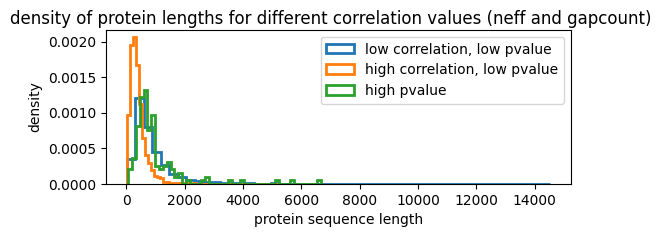

In [146]:
# NB: this is a density plot: we are not interested in the height of the 
# peaks, but in their location!
plt.figure(figsize=(6,2))
plt.suptitle("density of protein lengths for different correlation values (neff and gapcount)")
plt.hist(lowc_lens,bins=50,density=True,label="low correlation, low pvalue",histtype="step",lw=2)
plt.hist(highc_lens,bins=50,density=True,label="high correlation, low pvalue",histtype="step",lw=2)
plt.hist(highp_lens,bins=50,density=True,label="high pvalue",histtype="step",lw=2)
plt.xlabel("protein sequence length")
plt.ylabel("density")
plt.legend();

second, inspect MSAs: amino acid composition

In [123]:
def aa_comp(prot):
  """calculate amino acid composition for a specific protein"""
  msa = load_msa(f"{PROTEOME_NAME}/msas/{prot}.a3m")
  return Counter(msa[0])

In [130]:
highp_aacomp = sum(
  tqdm((aa_comp(prot) for prot in highp), total=len(highp)),
  start=Counter()
)
highc_aacomp = sum(
  tqdm((aa_comp(prot) for prot in highc), total=len(highc)),
  start=Counter()
)
lowc_aacomp = sum(
  tqdm((aa_comp(prot) for prot in lowc), total=len(lowc)),
  start=Counter()
)

100%|███████████████████████████████████████| 5875/5875 [04:42<00:00, 20.80it/s]


In [133]:
vocab = set(highp_aacomp) | set(highc_aacomp) | set(lowc_aacomp)
len(vocab),"".join(vocab)

(21, 'MSQGDETWHLVRNICYKPFAX')

In [176]:
a2i = {a:i for i,a in enumerate(vocab)}
i2a = {i:a for a,i in a2i.items()}

In [186]:
highp_aacomp_dict = dict(highp_aacomp)
highp_aacomp_axis = [
  highp_aacomp_dict[a] if a in highp_aacomp_dict else 0
  for a in sorted(a2i.keys())
]

In [187]:
highc_aacomp_dict = dict(highc_aacomp)
highc_aacomp_axis = [
  highc_aacomp_dict[a] if a in highc_aacomp_dict else 0
  for a in sorted(a2i.keys())
]

In [188]:
lowc_aacomp_dict = dict(lowc_aacomp)
lowc_aacomp_axis = [
  lowc_aacomp_dict[a] if a in lowc_aacomp_dict else 0
  for a in sorted(a2i.keys())
]

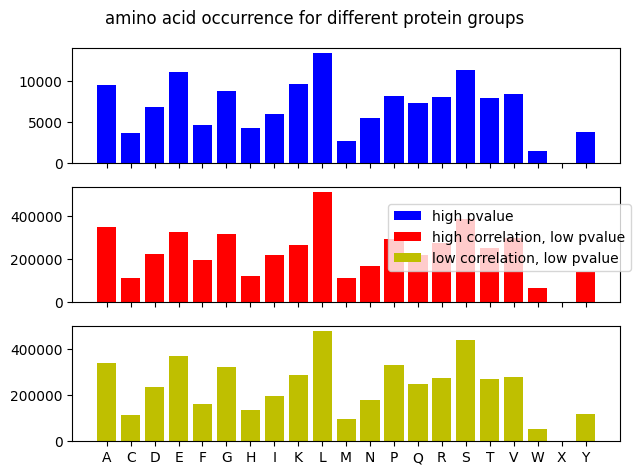

In [190]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=3,sharex=True)
fig.suptitle("amino acid occurrence for different protein groups")
ax1.bar(sorted(vocab),highp_aacomp_axis,label="high pvalue",color="b")
ax2.bar(sorted(vocab),highc_aacomp_axis,label="high correlation, low pvalue",color="r")
ax3.bar(sorted(vocab),lowc_aacomp_axis,label="low correlation, low pvalue",color="y")
fig.legend(loc="center right")
fig.tight_layout()